# Dinâmica Molecular Ab Initio usando VASP e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

from ase import Atoms
from ase.build import molecule
from ase.io import write, read
from ase.visualize import view

import numpy as np

# AIMD for Water in NVT Ensemble

Definindo uma caixa com várias moléculas de água

In [2]:
from ase.build import bulk

N = 32
rho_g_cm3 = 1.0  # density of water in g/cm^3

H2O = molecule('H2O')
molar_mass_amu = sum(H2O.get_masses())  # in amu

# mass of H2O ≈ 18.01528 g/mol; NA
NA = 6.02214076e23
mass_g = N * molar_mass_amu/ NA  # grams
vol_cm3 = mass_g / rho_g_cm3
vol_A3 = vol_cm3 * 1e24  # 1 cm^3 = 1e24 Å^3
L = vol_A3 ** (1/3)

Nx = int(np.ceil(np.power(N/4,1/3.0)))
dx = L/Nx

atoms = Atoms()

# Posições possíveis numa rede cristalina tipo FCC
id = 0
for i in range(Nx):
    for j in range(Nx):
        for k in range(Nx):
            if (id < N):
                x, y, z = i*dx, j*dx, k*dx
                mol = H2O.copy()
                mol.translate((x,y,z))
                atoms += mol
                id +=1

            if (id < N):
                x, y, z = i*dx, (j+0.5)*dx, (k+0.5)*dx
                mol = H2O.copy()
                mol.translate((x,y,z))
                atoms += mol
                id +=1

            if (id < N):
                x, y, z = (i+0.5)*dx, j*dx, (k+0.5)*dx
                mol = H2O.copy()
                mol.translate((x,y,z))
                atoms += mol
                id +=1

            if (id < N):
                x, y, z = (i+0.5)*dx, (j+0.5)*dx, k*dx
                mol = H2O.copy()
                mol.translate((x,y,z))
                atoms += mol
                id +=1

atoms.set_cell([L, L, L])
atoms.set_pbc([1, 1, 1])

Relaxando a geometria inicial

In [3]:
calc_relax = Vasp(
    directory='32h2o_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-6, ediffg=-0.01,
    isif=2, ibrion=2, nsw=100,
    nelm=100,
    ivdw=12,                       # D3(BJ) van der Waals correction
    lreal = 'Auto', lwave=False, lcharg=False, lvtot=False,
    atoms=atoms
)
calc_relax.calculate(atoms) # demora por volta de 37 s

E_atoms = atoms.get_potential_energy()

print(f'Optimized energy of 32 H2O: {E_atoms:.3f} eV')

Optimized energy of 32 H2O: -466.617 eV


Fazendo dinâmica molecular à 300 K por 5ps

In [ ]:
calc_aimd = Vasp(
    directory='aimd_32h2o_300K_5ps',
    xc='PBE',
    encut=450, 
    ismear=0, sigma=0.05,           # Gaussian smearing 
    prec = 'Normal',                # Normal precision
    algo = 'Fast',                  # Fast electronic minimization
    ibrion=0,                       # Molecular Dynamics
    isym=0,                         # Symmetry off (strongly recommended for MD)
    potim=0.5,                      # timestep 0.5 fs
    nsw=10000, isif=2,              # Number of MD steps
    mdalgo=4, setups='recommended', # Nosé-Hoover-Chain thermostat
    istart=0, lreal = 'Auto', lwave=False, lcharg=False,
    tebeg=300, teend=300,          # Start and Final temperature (300 K)
    ivdw=12,                       # D3(BJ) van der Waals correction
    atoms=atoms
)

calc_aimd.calculate(atoms) # demora por volta de 880 min

| N  | t (fs)| Elapsed Time (min)|
| ---|-------|-------------------|
| 27 | 5000 | 585               |
| 32 | 5000 | 880               |

In [ ]:
# Load all frames from XDATCAR
traj = read('aimd_32h2o_300K_5ps/XDATCAR', index=':')

print(f"Trajectory has {len(traj)} frames")
print(traj[0])  # first configuration

write('aimd_32h2o_300K_5ps/aimd.traj', traj)        # ASE binary trajectory
write('aimd_32h2o_300K_5ps/aimd.xyz', traj)         # Plain XYZ for external tools
write('aimd_32h2o_300K_5ps/aimd.pdb', traj)         # PDB format if preferred

Trajectory has 10000 frames
Atoms(symbols='H64O32', pbc=True, cell=[9.85548, 9.85548, 9.85548])


## Analisando $g(r)$

Comparar com 

Soper, A. K. "The radial distribution functions of water and ice from 220 to 673 K and at pressures up to 400 MPa." Chemical Physics 258.2-3 (2000): 121-137. https://doi.org/10.1016/S0301-0104(00)00179-8


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from ase.io import read
from ase.data import atomic_numbers

# ---------------- configuration ----------------
pdbfile = "aimd_32h2o_300K_5ps/aimd.pdb"
r_max_A = 12.0
n_bins  = 240
csv_out = "aimd_32h2o_300K_5ps/rdf.csv"
# ------------------------------------------------

# --- read all frames with ASE ---
frames = read(pdbfile, index=":")
natoms = len(frames[0])


# --- atomic identities ---
Z = frames[0].get_atomic_numbers()
O_idx = np.where(Z == atomic_numbers["O"])[0]
H_idx = np.where(Z == atomic_numbers["H"])[0]

# --- histogram accumulator ---
hist_OO = np.zeros(n_bins)
hist_OH = np.zeros(n_bins)
hist_HH = np.zeros(n_bins)

edges = np.linspace(0.0, r_max_A, n_bins+1)
dr = edges[1] - edges[0]
r = 0.5 * (edges[1:] + edges[:-1])

# --- helper for PBC distance matrix (triclinic) ---
def distance_matrix_pbc(positions, cell):
    """Return wrapped displacement vectors between all pairs (N,N,3)."""
    frac = np.linalg.solve(cell.T, positions.T).T  # to fractional coords
    dfrac = frac[:, np.newaxis, :] - frac[np.newaxis, :, :]
    dfrac -= np.round(dfrac)  # wrap into [-0.5, 0.5)
    return np.dot(dfrac, cell)  # back to Cartesian Å

# --- time control ---
dt_fs = 0.5 # used in the AIMD simulation
t_start_fs = 2500.0    # discard first 5000 fs
t_stride_fs = 10.0     # average every 10 fs

start_idx = int(t_start_fs / dt_fs)
stride = int(t_stride_fs / dt_fs)
frames_to_use = frames[start_idx::stride]
nframes = len(frames_to_use)

# --- accumulate over frames ---
for ats in frames_to_use:
    # ats.repeat((2,2,2))
    pos = ats.get_positions()          # Å
    cell = ats.get_cell().array        # (3,3) Å

    disp = distance_matrix_pbc(pos, cell)
    dist = np.linalg.norm(disp, axis=-1)

    # mask upper triangle to avoid double counting
    iu = np.triu_indices(natoms, 1)

    # O–O
    mask = np.isin(iu[0], O_idx) & np.isin(iu[1], O_idx)
    hist_OO += np.histogram(dist[iu][mask], bins=edges)[0]
    # O–H
    mask = np.isin(iu[0], O_idx) & np.isin(iu[1], H_idx)
    hist_OH += np.histogram(dist[iu][mask], bins=edges)[0]
    mask = np.isin(iu[0], H_idx) & np.isin(iu[1], O_idx)
    hist_OH += np.histogram(dist[iu][mask], bins=edges)[0]  # symmetric
    # H–H
    mask = np.isin(iu[0], H_idx) & np.isin(iu[1], H_idx)
    hist_HH += np.histogram(dist[iu][mask], bins=edges)[0]

# number densities
cell = frames[0].get_cell().array
vol = np.abs(np.linalg.det(cell))  # Å³

rho_OO = len(O_idx)*len(O_idx)/2 / vol
rho_OH = len(H_idx)*len(O_idx) / vol
rho_HH = len(H_idx)*len(H_idx)/2 / vol

# normalization constants
def normalize(hist,rho_j):
    """Convert histogram counts to g(r)."""
    shell_vol = (4.0 * np.pi/ 3.0) * (edges[1:]**3 - edges[:-1]**3)
    norm =  rho_j * shell_vol * nframes
    return hist / norm

g_OO = normalize(hist_OO, rho_OO)
g_OH = normalize(hist_OH, rho_OH)
g_HH = normalize(hist_HH, rho_HH)

# --- save ---
data = np.column_stack([r, g_OO, g_OH, g_HH])
np.savetxt(csv_out, data, delimiter=",", header="r_A,g_OO,g_OH,g_HH", comments="")

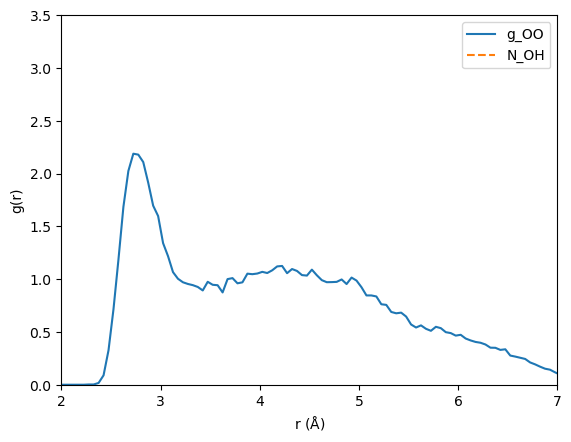

In [ ]:
plt.figure()
plt.plot(r, g_OO, label="g_OO")
plt.xlabel(r"r ($\mathrm{\AA}$)")
plt.ylabel(r"g(r)")
plt.legend()
plt.xlim(2, 7)
plt.ylim(0,3.5)
plt.show()

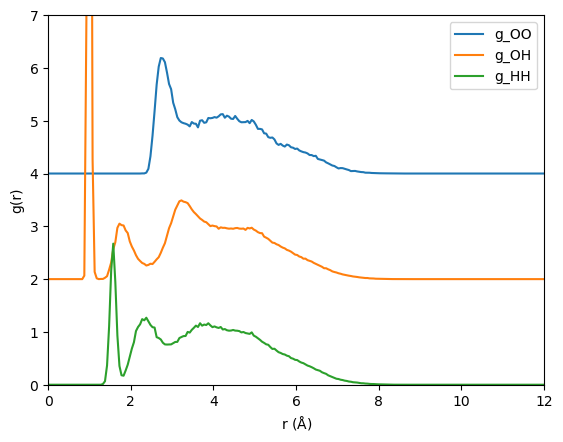

In [56]:
plt.figure()
plt.plot(r, g_OO+4, label="g_OO")
plt.plot(r, g_OH+2, label="g_OH")
plt.plot(r, g_HH, label="g_HH")
plt.xlabel(r"r ($\mathrm{\AA}$)")
plt.ylabel(r"g(r)")
plt.legend()
plt.xlim(0, 12)
plt.ylim(0,7)
plt.show()